# Test model output

The following notebook contains tests of the output generated by model.
The tests check the legality of predicted moves and the correctness of predicted game result.

The tests are performed for model trained on tokenization with additional info about player to move (18 tokens)

In [1]:
import os
import pickle
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from model import GPTConfig, GPT
from c4engine import C4Engine

In [2]:
OUT_DIR = 'out-connect-four-player'
DEVICE = 'cuda'

In [3]:
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = torch.amp.autocast(device_type=DEVICE, dtype=ptdtype)

Load model

In [4]:
# init from a model saved in a specific directory
ckpt_path = os.path.join(OUT_DIR, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=DEVICE)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model.eval()
model.to(DEVICE)
# model = torch.compile(model)

number of parameters: 10.63M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(18, 384)
    (wpe): Embedding(44, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=18, bias=False)
)

Load dataset

In [5]:
# read metadata
data_dir = os.path.join('data', checkpoint['config']['dataset'])
meta_path = os.path.join(data_dir, 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)

# get encode/decode - tokenizer
stoi, itos, stom, separator = meta['stoi'], meta['itos'], meta['stom'], meta['separator']
split = lambda s: list(s) if separator == '' else s.split(separator)
encode = lambda s: [stoi[c] for c in split(s)]
decode = lambda l: separator.join(itos[i] for i in l)
str_to_moves = lambda s: ''.join(stom[c] for c in split(s))
ids_to_moves = lambda l: ''.join(stom[itos[i]] for i in l)

eos_token_ids = meta['eos_token_ids']

# read dataset
block_size = meta['block_size']
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)

## Legal move and game result prediction

In [6]:
def test_legal_move_and_game_result_prediction(data):
    move_seqs = set()
    correct_legal, total_legal = 0, 0
    correct_result, total_result = 0, 0

    for seq in data:
        engine = C4Engine()
        seq_moves = ids_to_moves(seq)
        for i in range(len(seq)):
            engine.make_move(seq_moves[i])

            if seq_moves[:i+1] in move_seqs:
                continue
            move_seqs.add(seq_moves[:i+1])

            # predict next token (move or game result)
            x = (torch.tensor(seq[:i+1], dtype=torch.long, device=DEVICE)[None, ...])
            y = model.generate(idx=x, max_new_tokens=1, top_k=1)
            predicted = ids_to_moves(y[0].tolist())[-1]

            # if game finished check predicted result
            if engine.result() is not None:
                if predicted == engine.result():
                    correct_result += 1
                total_result += 1
                break

            # check if predicted move is legal
            if engine.is_legal_move(predicted):
                correct_legal += 1
            total_legal += 1

    return correct_legal, total_legal, correct_result, total_result

In [7]:
correct_legal_val, total_legal_val, correct_result_val, total_result_val = test_legal_move_and_game_result_prediction(val_data)

In [8]:
print(f"Legal moves predicted (validation data): {correct_legal_val}/{total_legal_val} ({100.0*correct_legal_val/total_legal_val:.2f}%)")
print(f"Game result predicted (validation data): {correct_result_val}/{total_result_val} ({100.0*correct_result_val/total_result_val:.2f}%)")

Legal moves predicted (validation data): 59198/59665 (99.22%)
Game result predicted (validation data): 1676/2000 (83.80%)


In [9]:
correct_legal_train, total_legal_train, correct_result_train, total_result_train = test_legal_move_and_game_result_prediction(train_data)

In [10]:
print(f"Legal moves predicted (training data): {correct_legal_train}/{total_legal_train} ({100.0*correct_legal_train/total_legal_train:.2f}%)")
print(f"Game result predicted (training data): {correct_result_train}/{total_result_train} ({100.0*correct_result_train/total_result_train:.2f}%)")

Legal moves predicted (training data): 495395/498639 (99.35%)
Game result predicted (training data): 16244/18000 (90.24%)


## Probing

### Get output from hidden layers of the model

In [11]:
activations = {}

def get_hook(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks on each block
for i, block in enumerate(model.transformer.h):
    block.register_forward_hook(get_hook(f'block_{i}'))

### Prepare dataset

In [12]:
field_to_int = {C4Engine.EMPTY: 0, C4Engine.PLAYERS[0]: 1, C4Engine.PLAYERS[1]: 2}
rng = np.random.default_rng(seed=9128)

def get_probe_dataset(data):
    move_seqs = set()
    X = []
    Y_cell = []
    Y_col = []
    Y_row = []

    for seq in data:
        i = rng.integers(1, len(seq))
        seq_moves = ids_to_moves(seq[:i])
        # seq_moves = ids_to_moves(seq)
        # engine = C4Engine()
        # for i in range(len(seq)):
        # engine.make_move(seq_moves[i])
        engine = C4Engine(seq_moves)

        # if seq_moves[:i+1] in move_seqs:
        #     continue
        # move_seqs.add(seq_moves[:i+1])
        if seq_moves in move_seqs:
            continue
        move_seqs.add(seq_moves)

        board = engine.board()

        inp = (torch.tensor(seq[:i], dtype=torch.long, device=DEVICE)[None, ...])
        # inp = (torch.tensor(seq[:i+1], dtype=torch.long, device=DEVICE)[None, ...])
        _, _ = model(inp)
        X.append(activations['block_5'][:, -1, :].reshape(-1).cpu())
        Y_cell.append(torch.tensor([field_to_int[f] for row in board for f in row]))
        Y_col.append(torch.tensor([sum(1 for i in range(6) if board[i][j] in C4Engine.PLAYERS) for j in range(7)]))
        Y_row.append(torch.tensor([sum(1 for c in row if c in C4Engine.PLAYERS) for row in board]))

        # if engine.result() is not None:
        #     break

    X = torch.stack(X)
    Y_cell = torch.stack(Y_cell)
    Y_col = torch.stack(Y_col)
    Y_row = torch.stack(Y_row)

    return X, Y_cell, Y_col, Y_row

In [13]:
train_X, train_Y_cell, train_Y_col, train_Y_row = get_probe_dataset(train_data)

In [14]:
train_X.shape, train_Y_cell.shape, train_Y_col.shape, train_Y_row.shape

(torch.Size([16304, 384]),
 torch.Size([16304, 42]),
 torch.Size([16304, 7]),
 torch.Size([16304, 6]))

In [15]:
val_X, val_Y_cell, val_Y_col, val_Y_row = get_probe_dataset(val_data)

In [16]:
val_X.shape, val_Y_cell.shape, val_Y_col.shape, val_Y_row.shape

(torch.Size([1892, 384]),
 torch.Size([1892, 42]),
 torch.Size([1892, 7]),
 torch.Size([1892, 6]))

### Train linear probes

In [17]:
class LinearBoardProbe(nn.Module):
    def __init__(self, dim_x, dim_y, num_cls):
        super().__init__()
        # 42 cells × 3 classes
        self._dim_x = dim_x
        self._dim_y = dim_y
        self._num_cls = num_cls
        self.linear = nn.Linear(dim_x, dim_y * num_cls, device=DEVICE)

    def forward(self, x):
        # x: (B,384)
        out = self.linear(x)
        return out.view(-1, self._dim_y, self._num_cls)

In [18]:
def get_data_loader(X, Y, batch_size=1024):
    dataset = torch.utils.data.TensorDataset(X, Y)
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True)

In [19]:
def train_probe(X, Y, num_cls):
    probe = LinearBoardProbe(dim_x=X.shape[-1], dim_y=Y.shape[-1], num_cls=num_cls).to(DEVICE)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(
        probe.parameters(),
        lr=3e-4,
        weight_decay=1e-4
    )

    epochs = 1024
    batch_size = 1024

    train_loader = get_data_loader(X, Y, batch_size)

    for epoch in range(epochs):
        total_loss = 0
        for x, y in train_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            preds = probe(x)

            loss = criterion(
                preds.view(-1, probe._num_cls),
                y.view(-1)
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch:3d}: {total_loss/len(train_loader):.4f}')

    return probe, train_loader

Predict value of each cell

In [20]:
cell_probe, cell_train_loader = train_probe(train_X, train_Y_cell, num_cls=3)

Epoch   0: 1.4473
Epoch   1: 0.9462
Epoch   2: 0.8080
Epoch   3: 0.7349
Epoch   4: 0.6841
Epoch   5: 0.6456
Epoch   6: 0.6149
Epoch   7: 0.5901
Epoch   8: 0.5697
Epoch   9: 0.5527
Epoch  10: 0.5385
Epoch  11: 0.5258
Epoch  12: 0.5149
Epoch  13: 0.5052
Epoch  14: 0.4969
Epoch  15: 0.4891
Epoch  16: 0.4823
Epoch  17: 0.4761
Epoch  18: 0.4702
Epoch  19: 0.4649
Epoch  20: 0.4601
Epoch  21: 0.4556
Epoch  22: 0.4513
Epoch  23: 0.4475
Epoch  24: 0.4438
Epoch  25: 0.4404
Epoch  26: 0.4372
Epoch  27: 0.4340
Epoch  28: 0.4311
Epoch  29: 0.4284
Epoch  30: 0.4258
Epoch  31: 0.4235
Epoch  32: 0.4210
Epoch  33: 0.4188
Epoch  34: 0.4165
Epoch  35: 0.4146
Epoch  36: 0.4125
Epoch  37: 0.4106
Epoch  38: 0.4087
Epoch  39: 0.4071
Epoch  40: 0.4054
Epoch  41: 0.4036
Epoch  42: 0.4021
Epoch  43: 0.4006
Epoch  44: 0.3990
Epoch  45: 0.3978
Epoch  46: 0.3963
Epoch  47: 0.3950
Epoch  48: 0.3938
Epoch  49: 0.3924
Epoch  50: 0.3912
Epoch  51: 0.3899
Epoch  52: 0.3888
Epoch  53: 0.3879
Epoch  54: 0.3867
Epoch  55:

Predict number of pieces in each column

In [21]:
col_probe, col_train_loader = train_probe(train_X, train_Y_col, num_cls=7)

Epoch   0: 2.5051
Epoch   1: 1.7904
Epoch   2: 1.5324
Epoch   3: 1.3840
Epoch   4: 1.2830
Epoch   5: 1.2057
Epoch   6: 1.1438
Epoch   7: 1.0924
Epoch   8: 1.0485
Epoch   9: 1.0115
Epoch  10: 0.9795
Epoch  11: 0.9510
Epoch  12: 0.9249
Epoch  13: 0.9023
Epoch  14: 0.8817
Epoch  15: 0.8630
Epoch  16: 0.8459
Epoch  17: 0.8294
Epoch  18: 0.8150
Epoch  19: 0.8016
Epoch  20: 0.7889
Epoch  21: 0.7769
Epoch  22: 0.7656
Epoch  23: 0.7551
Epoch  24: 0.7454
Epoch  25: 0.7362
Epoch  26: 0.7272
Epoch  27: 0.7192
Epoch  28: 0.7110
Epoch  29: 0.7035
Epoch  30: 0.6962
Epoch  31: 0.6896
Epoch  32: 0.6827
Epoch  33: 0.6758
Epoch  34: 0.6697
Epoch  35: 0.6638
Epoch  36: 0.6579
Epoch  37: 0.6528
Epoch  38: 0.6474
Epoch  39: 0.6421
Epoch  40: 0.6370
Epoch  41: 0.6329
Epoch  42: 0.6280
Epoch  43: 0.6233
Epoch  44: 0.6191
Epoch  45: 0.6145
Epoch  46: 0.6106
Epoch  47: 0.6066
Epoch  48: 0.6027
Epoch  49: 0.5988
Epoch  50: 0.5951
Epoch  51: 0.5916
Epoch  52: 0.5884
Epoch  53: 0.5850
Epoch  54: 0.5816
Epoch  55:

Predict number of pieces in each row

In [22]:
row_probe, row_train_loader = train_probe(train_X, train_Y_row, num_cls=8)

Epoch   0: 2.7643
Epoch   1: 1.8681
Epoch   2: 1.5788
Epoch   3: 1.4346
Epoch   4: 1.3404
Epoch   5: 1.2702
Epoch   6: 1.2144
Epoch   7: 1.1695
Epoch   8: 1.1320
Epoch   9: 1.1010
Epoch  10: 1.0737
Epoch  11: 1.0505
Epoch  12: 1.0299
Epoch  13: 1.0116
Epoch  14: 0.9958
Epoch  15: 0.9810
Epoch  16: 0.9678
Epoch  17: 0.9553
Epoch  18: 0.9441
Epoch  19: 0.9337
Epoch  20: 0.9243
Epoch  21: 0.9151
Epoch  22: 0.9065
Epoch  23: 0.8986
Epoch  24: 0.8915
Epoch  25: 0.8843
Epoch  26: 0.8780
Epoch  27: 0.8721
Epoch  28: 0.8658
Epoch  29: 0.8605
Epoch  30: 0.8543
Epoch  31: 0.8488
Epoch  32: 0.8438
Epoch  33: 0.8391
Epoch  34: 0.8347
Epoch  35: 0.8302
Epoch  36: 0.8259
Epoch  37: 0.8214
Epoch  38: 0.8173
Epoch  39: 0.8138
Epoch  40: 0.8105
Epoch  41: 0.8066
Epoch  42: 0.8031
Epoch  43: 0.7998
Epoch  44: 0.7971
Epoch  45: 0.7938
Epoch  46: 0.7903
Epoch  47: 0.7873
Epoch  48: 0.7847
Epoch  49: 0.7816
Epoch  50: 0.7790
Epoch  51: 0.7763
Epoch  52: 0.7734
Epoch  53: 0.7705
Epoch  54: 0.7685
Epoch  55:

### Test linear probes

In [23]:
def eval_probe(probe, loader, dim):
    correct = torch.zeros(dim, device=DEVICE)
    total = torch.zeros(dim, device=DEVICE)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            preds = probe(x)
            pred_cls = preds.argmax(dim=-1)
            matches = (pred_cls == y).float()

            correct += matches.sum(dim=0)
            total += torch.ones_like(matches).sum(dim=0)

    return correct / total

In [24]:
def plot_heatmap(acc, w, h, title, xlabel, ylabel, disable_yticks=False, disable_xticks=False):
    board = acc.view(h, w).cpu()

    plt.figure()
    plt.imshow(board)
    plt.colorbar(label='Accuracy')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if disable_yticks:
        plt.yticks([])
    if disable_xticks:
        plt.xticks([])

    for i in range(h):
        for j in range(w):
            val = board[i, j].item()
            plt.text(
                j, i,
                f'{val:.2f}',
                ha='center',
                va='center'
            )

    plt.show()

Per cell

In [25]:
train_acc_cell = eval_probe(cell_probe, cell_train_loader, dim=train_Y_cell.shape[-1])
train_acc_cell

tensor([0.9181, 0.9085, 0.9173, 0.9123, 0.9428, 0.9571, 0.9796, 0.8635, 0.8505,
        0.8586, 0.8574, 0.8889, 0.9197, 0.9545, 0.8094, 0.8067, 0.8235, 0.8236,
        0.8387, 0.8703, 0.9228, 0.8005, 0.8023, 0.8179, 0.8157, 0.8397, 0.8579,
        0.8946, 0.7956, 0.7765, 0.7967, 0.8358, 0.8112, 0.8382, 0.8637, 0.8262,
        0.8288, 0.8770, 0.9068, 0.8503, 0.8365, 0.8545], device='cuda:0')

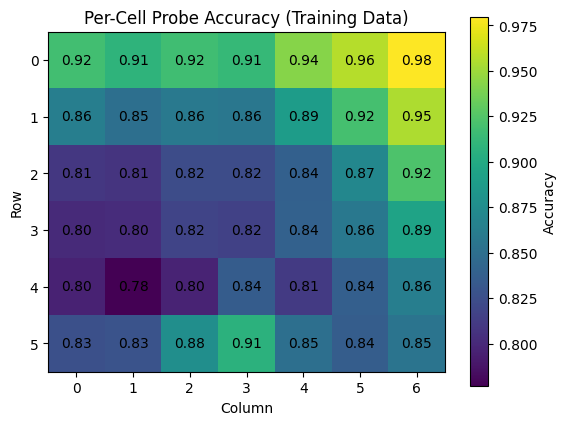

In [26]:
plot_heatmap(train_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Training Data)', xlabel='Column', ylabel='Row')

In [27]:
cell_val_loader = get_data_loader(val_X, val_Y_cell)
val_acc_cell = eval_probe(cell_probe, cell_val_loader, val_Y_cell.shape[-1])
val_acc_cell

tensor([0.9181, 0.8975, 0.9091, 0.8996, 0.9255, 0.9456, 0.9736, 0.8499, 0.8388,
        0.8441, 0.8383, 0.8689, 0.8932, 0.9477, 0.7970, 0.7997, 0.7997, 0.8166,
        0.8277, 0.8584, 0.9091, 0.7817, 0.7785, 0.8029, 0.8087, 0.8018, 0.8488,
        0.8732, 0.7801, 0.7711, 0.7865, 0.8388, 0.8113, 0.8229, 0.8599, 0.8124,
        0.8155, 0.8816, 0.9054, 0.8499, 0.8293, 0.8235], device='cuda:0')

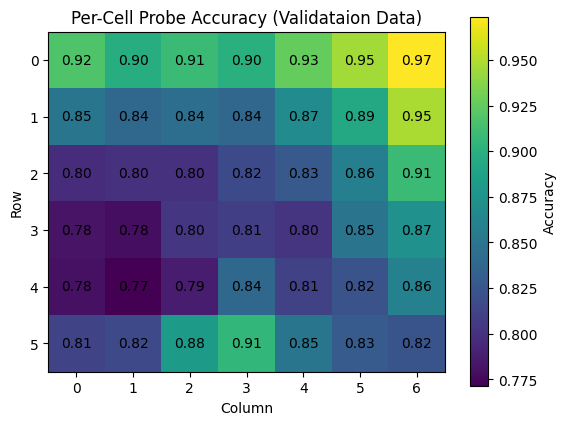

In [28]:
plot_heatmap(val_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Validataion Data)', xlabel='Column', ylabel='Row')

Per column

In [29]:
train_acc_col = eval_probe(col_probe, col_train_loader, dim=train_Y_col.shape[-1])
train_acc_col

tensor([0.9293, 0.9183, 0.9218, 0.9419, 0.9144, 0.9076, 0.8830],
       device='cuda:0')

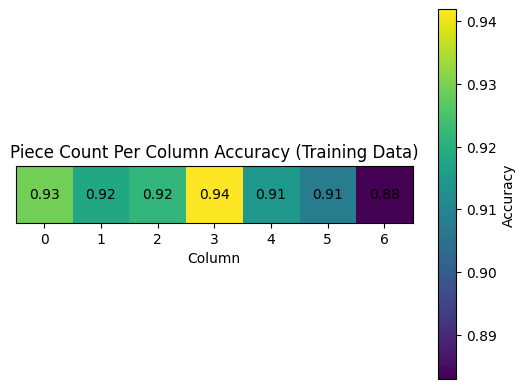

In [30]:
plot_heatmap(train_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Training Data)', xlabel='Column', ylabel='', disable_yticks=True)

In [31]:
col_val_loader = get_data_loader(val_X, val_Y_col)
val_acc_col = eval_probe(col_probe, col_val_loader, val_Y_col.shape[-1])
val_acc_col

tensor([0.9027, 0.8922, 0.8964, 0.9244, 0.9012, 0.8790, 0.8335],
       device='cuda:0')

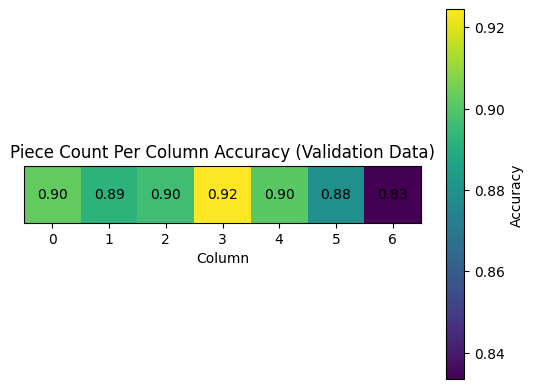

In [32]:
plot_heatmap(val_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Validation Data)', xlabel='Column', ylabel='', disable_yticks=True)

Per row

In [33]:
train_acc_row = eval_probe(row_probe, row_train_loader, dim=train_Y_row.shape[-1])
train_acc_row

tensor([0.8847, 0.7694, 0.7705, 0.7689, 0.7620, 0.7981], device='cuda:0')

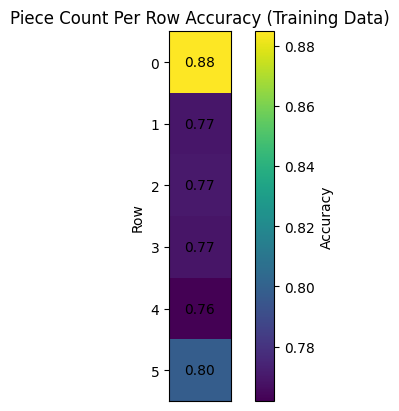

In [34]:
plot_heatmap(train_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Training Data)', xlabel='', ylabel='Row', disable_xticks=True)

In [35]:
row_val_loader = get_data_loader(val_X, val_Y_row)
val_acc_row = eval_probe(row_probe, row_val_loader, val_Y_row.shape[-1])
val_acc_row

tensor([0.8663, 0.7283, 0.7278, 0.7378, 0.7088, 0.7606], device='cuda:0')

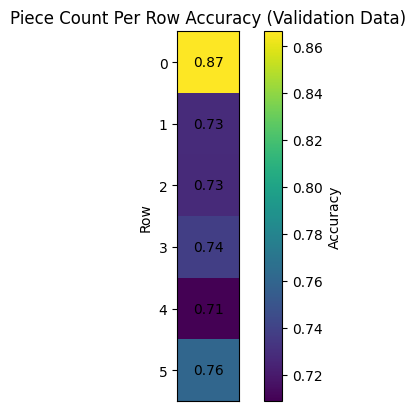

In [36]:
plot_heatmap(val_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Validation Data)', xlabel='', ylabel='Row', disable_xticks=True)